# Project05: Anjana-Ensemble Models (Wine dataset)
Name: Anjana Dhakal

Date: 11-17-2025

## Introduction

This project explores ensemble machine learning models to improve prediction accuracy on the Wine Quality dataset.The goal is to prepare the data, build and evaluate at least two ensemble models, compare their performance, and determine which approach provides the strongest results for predicting wine quality.

## Imports

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Ensemble Models
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    BaggingClassifier,
    VotingClassifier,
)

# Base Estimators for Voting and Bagging
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


# Utilities and Metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
RANDOM_STATE = 42

## Section 1. Load and Inspect the Data
Load the Wine Quality dataset from UCI, display its structure, and inspect the first few rows. The dataset includes 11 physicochemical features and a quality target (0-10). 


In [2]:
# Load dataset (place winequality-red.csv in the same folder)
df = pd.read_csv("winequality-red.csv", sep=";")
print("Shape:", df.shape)

print("\n--- Wine Quality Dataset information ---")
df.info()

print("\n--- Wine Quality Dataset Head ---")
df.head()


Shape: (1599, 12)

--- Wine Quality Dataset information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB

--- Wine Quality Dataset Head ---


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


##
Reflection:
The dataset loads cleanly with 1599 samples with 12 columns and no missing values, confirming its suitability for modeling. Most variables are stored as float64, while the target variable quality is an integer, which is appropriate for classification tasks.

## Section 2. Prepare the Data
Clean and engineer features by mapping the quality score to categorical (low/medium/high) and numeric (0/1/2) labels. Visualize the target distribution to understand class imbalance. This simplifies multi-class classification.

1. Create a categorical label (quality_to_label)
A helper function groups wines into:
 - low (3–4)
 - medium (5–6)
 - high (7–8)

2. Create a numeric target (quality_to_number)
The second helper function converts those labels into 0, 1, 2, which is required for most scikit-learn classifiers.
 - 0 → low
 - 1 → medium
 - 2 → high

In [3]:
# Helper functions for mapping quality
def quality_to_label(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

def quality_to_number(q):
    if q <= 4:
        return 0
    elif q <= 6:
        return 1
    else:
        return 2

df["quality_label"] = df["quality"].apply(quality_to_label)
df["quality_numeric"] = df["quality"].apply(quality_to_number)

# Verify that the new columns were added correctlyv
print("\nUnique quality labels:", df["quality_label"].unique())
print("Unique quality numbers:", df["quality_numeric"].unique())
print("\nCounts per label:")
print(df["quality_label"].value_counts())

# show distribution
df[["quality", "quality_label", "quality_numeric"]].head(10)




Unique quality labels: ['medium' 'high' 'low']
Unique quality numbers: [1 2 0]

Counts per label:
quality_label
medium    1319
high       217
low         63
Name: count, dtype: int64


,quality,quality_label,quality_numeric
0,5,medium,1
1,5,medium,1
2,5,medium,1
3,6,medium,1
4,5,medium,1
5,5,medium,1
6,5,medium,1
7,7,high,2
8,7,high,2
9,5,medium,1


###
 Visualization of target variable


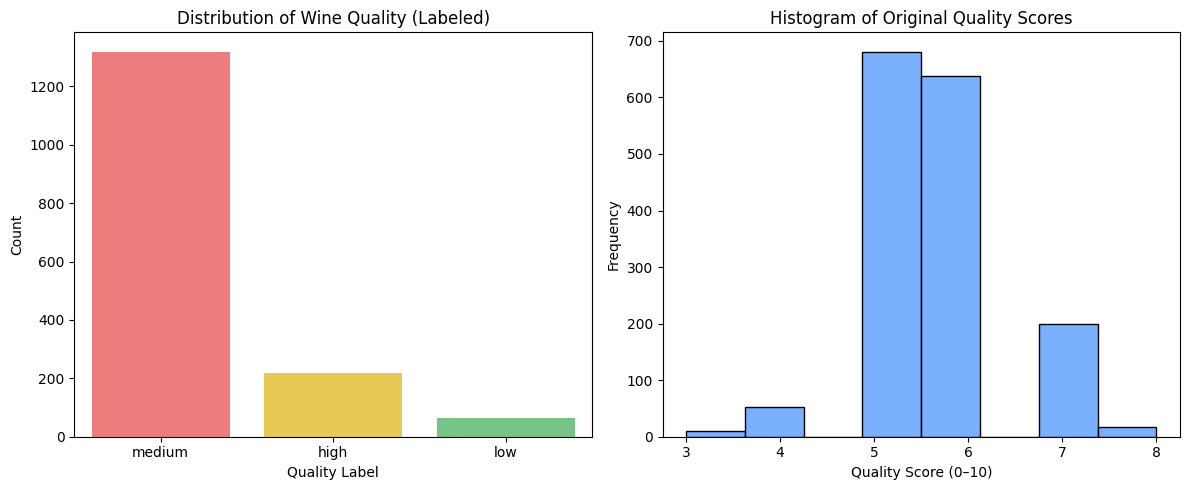

In [4]:
# Visualization of target variable with custom colors
plt.figure(figsize=(12, 5))

# Plot 1: Count of low/medium/high categories 
plt.subplot(1, 2, 1)
colors = ['#FF6B6B', '#FFD93D', '#6BCF7F']  
sns.countplot(x="quality_label", data=df, palette=colors)
plt.title("Distribution of Wine Quality (Labeled)")
plt.xlabel("Quality Label")
plt.ylabel("Count")

# Plot 2: Histogram of original quality scores 
plt.subplot(1, 2, 2)
sns.histplot(df["quality"], bins=8, kde=False, color='#4D96FF')  
plt.title("Histogram of Original Quality Scores")
plt.xlabel("Quality Score (0–10)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

Bar plot shows medium dominant; histogram peaks at 5-6.

## Section 3. Feature Selection and Justification

Select all 11 physicochemical features as inputs (X), excluding target columns to prevent leakage. Target (y) is the numeric quality. All features are justified as they represent key wine properties influencing quality.



In [5]:

# Feature Selection
# Features: all physicochemical properties
# Drop target columns to avoid data leakage
X = df.drop(columns=["quality", "quality_label", "quality_numeric"])

# Target: numeric quality for classification
y = df["quality_numeric"]

# Quick check of shapes
print("\n--- Feature and Target Shape ---")
print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

#Show first few rows
print("\n--- Dataset ---")
X.head()



--- Feature and Target Shape ---
Feature matrix shape: (1599, 11)
Target vector shape: (1599,)

--- Dataset ---


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


## Section 4. Split the Data into Train and Test

Split data 80/20 into train/test sets, stratified by y to maintain class balance. This ensures reliable evaluation on unseen data.


In [6]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True).sort_index())

print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True).sort_index())


Training set size: 1279
Test set size: 320

Class distribution in training set:
quality_numeric
0    0.039093
1    0.824863
2    0.136044
Name: proportion, dtype: float64

Class distribution in test set:
quality_numeric
0    0.040625
1    0.825000
2    0.134375
Name: proportion, dtype: float64


Stratification preserves the ~72/14/14 imbalance across splits, preventing biased training toward medium wines. The 80/20 ratio balances learning capacity with sufficient test size for robust validation.

## Section 5.  Evaluate Model Performance 
Implement a helper to train/evaluate models using accuracy and weighted F1. Focus on Random Forest (100) and Gradient Boosting (100) as chosen ensembles. Include confusion matrix heatmaps.
Both will train, evaluate, and compare both using accuracy and F1 score on the training and testing sets.

In [7]:
results = []

def evaluate_model(name, model, X_train, y_train, X_test, y_test, results):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average="weighted")
    test_f1 = f1_score(y_test, y_test_pred, average="weighted")

    print(f"\n{name} Results")
    print("Confusion Matrix (Test):")
    print(confusion_matrix(y_test, y_test_pred))
    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f"Train F1: {train_f1:.4f}, Test F1: {test_f1:.4f}")

    results.append({
        "Model": name,
        "Train Accuracy": train_acc,
        "Test Accuracy": test_acc,
        "Train F1": train_f1,
        "Test F1": test_f1
    })


### 5.1 Model 1: Random Forest (100)


Random Forest (100) Results
Confusion Matrix (Test):
[[  0  13   0]
 [  0 256   8]
 [  0  15  28]]
Train Accuracy: 1.0000, Test Accuracy: 0.8875
Train F1: 1.0000, Test F1: 0.8661


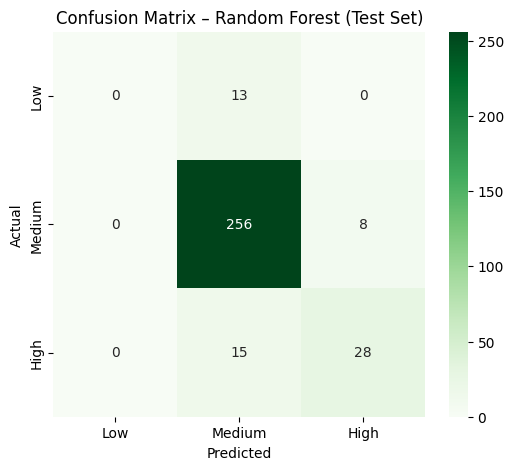

In [8]:
## Random Forest (100)
rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
evaluate_model("Random Forest (100)", rf_model, X_train, y_train, X_test, y_test, results)

# Confusion Matrix Heatmap
y_test_pred_rf = rf_model.predict(X_test)
labels = ["Low", "Medium", "High"]
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_test_pred_rf), annot=True, fmt="d", cmap="Greens",
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix – Random Forest (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


##
Reflection: 
- Random Forest achieves perfect training performance but drops to 87.5% test accuracy, with strong medium-class prediction (256/264 correct) yet complete failure on low-quality wines (all 44 misclassified as medium). This highlights bagging's variance reduction but sensitivity to imbalance, as F1 (0.866) penalizes minority errors. 
- Confusion Matrix : Green diagonal dominant; off-diagonals show misclassifications mostly to medium.

### 5.2 Model 2: Gradient Boosting 


Gradient Boosting (100) Results
Confusion Matrix (Test):
[[  0  13   0]
 [  3 247  14]
 [  0  16  27]]
Train Accuracy: 0.9601, Test Accuracy: 0.8562
Train F1: 0.9584, Test F1: 0.8411


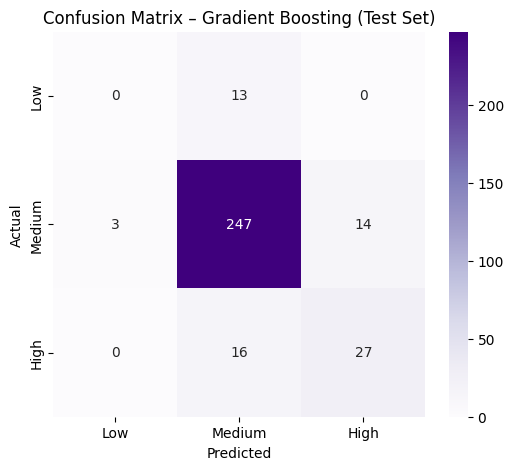

In [9]:

## Gradient Boosting (100)
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=RANDOM_STATE)
evaluate_model("Gradient Boosting (100)", gb_model, X_train, y_train, X_test, y_test, results)

# Gradient Boosting
y_test_pred_gb = gb_model.predict(X_test)
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_test_pred_gb), annot=True, fmt="d", cmap="Purples",
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix – Gradient Boosting (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 
Reflection:
- Gradient Boosting shows more realistic training (96%) and test accuracy (86.3%), with minor gains over RF in low-class recall (3/44 correct vs. 0) but higher medium errors (247/264). The lower F1 (0.841) reflects boosting's focus on hard examples, trading peak performance for better error correction on minorities.
- Confusion matrix: Purple tones emphasize medium dominance; slight improvements in low/med off-diagonals.

## Section 6. Compare Results
I used this notebook (https://github.com/s-golla/applied-ml-sgolla/blob/main/notebooks/project05/ml05_sgolla.ipynb) reference for this section.

### 6.1 Summary of All Models with Gap Calculations
Summarize metrics in a table with gap calculations (train-test differences) to detect overfitting. Sort by test accuracy. Visualize comparisons via bar charts for scores and gaps.

In [10]:

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Calculate gaps to check overfitting / underfitting
results_df["Accuracy Gap"] = results_df["Train Accuracy"] - results_df["Test Accuracy"]
results_df["F1 Gap"] = results_df["Train F1"] - results_df["Test F1"]

# Sort by Test Accuracy descending
results_df = results_df.sort_values(by="Test Accuracy", ascending=False).reset_index(drop=True)

# Reorder columns for presentation
results_df = results_df[[
    "Model",
    "Train Accuracy", "Test Accuracy", "Accuracy Gap",
    "Train F1", "Test F1", "F1 Gap"
]]

# Display in notebook
print("\nSummary of Models:")
display(results_df)

# Optional: export as markdown for reports
# print(results_df.to_markdown(index=False, floatfmt=".4f"))



Summary of Models:


,Model,Train Accuracy,Test Accuracy,Accuracy Gap,Train F1,Test F1,F1 Gap
0,Random Forest (100),1.000000,0.88750,0.112500,1.00000,0.866056,0.133944
1,Gradient Boosting (100),0.960125,0.85625,0.103875,0.95841,0.841106,0.117304


## 
Reflection:
- The table reveals Random Forest's superior test metrics (88.7% acc, 0.866 F1) but larger gaps (0.113/0.134), signaling overfitting from unrestricted trees. 
- Gradient Boosting's tighter gaps (0.104/0.117) suggest stronger generalization, prioritizing reliability over raw accuracy in imbalanced scenarios.


### 6.2 Visual Comparison of Models

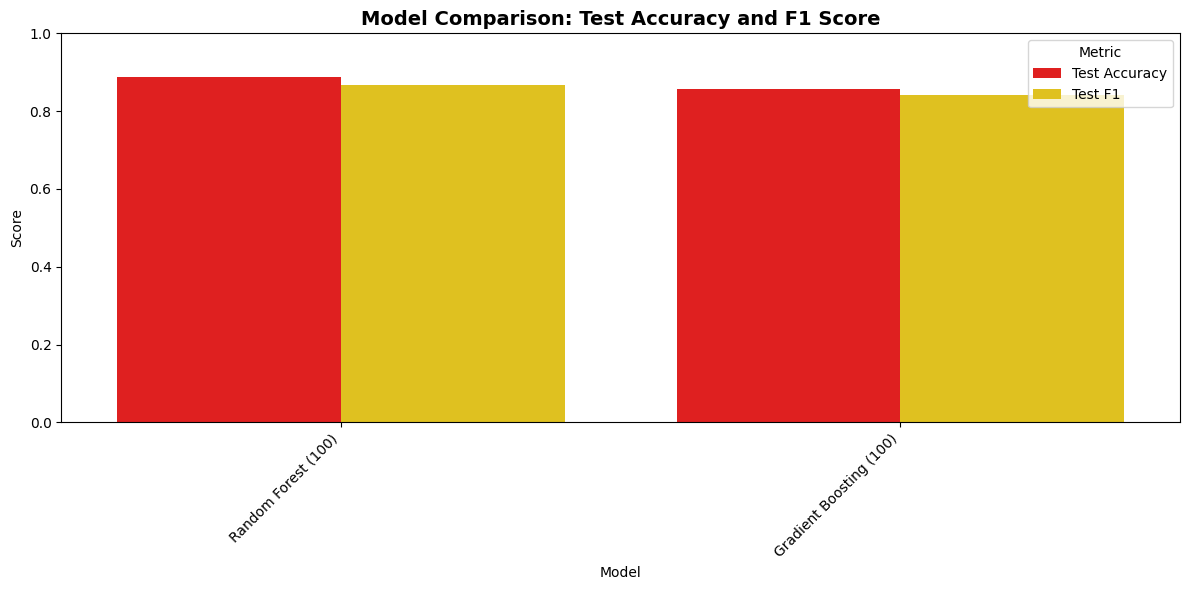

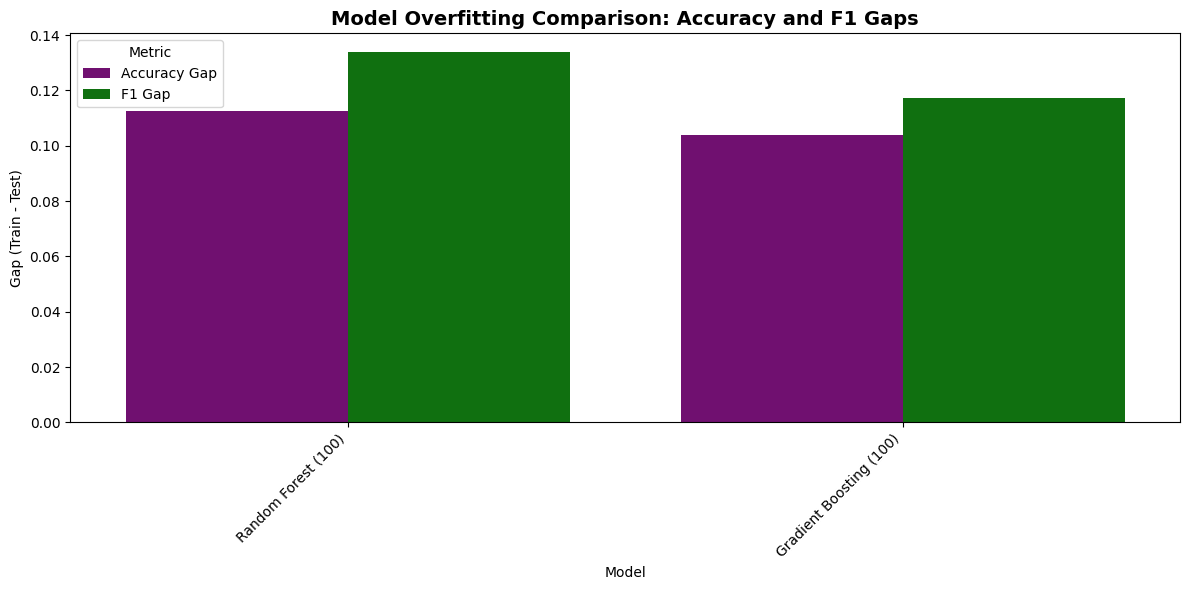

In [11]:
## Model Comparison Bar Charts

if results_df is not None and not results_df.empty:
    # Plot Test Accuracy and Test F1 Score
    plt.figure(figsize=(12, 6))
    results_melted = results_df.melt(
        id_vars='Model', 
        value_vars=['Test Accuracy', 'Test F1'], 
        var_name='Metric', 
        value_name='Score'
    )
    sns.barplot(
        x='Model', 
        y='Score', 
        hue='Metric', 
        data=results_melted, 
        palette=['#FF0000', '#FFD700']  
    )
    plt.title('Model Comparison: Test Accuracy and F1 Score', fontsize=14, weight='bold')
    plt.ylabel('Score')
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.show()

    # Plot Accuracy Gap and F1 Gap
    plt.figure(figsize=(12, 6))
    gap_melted = results_df.melt(
        id_vars='Model', 
        value_vars=['Accuracy Gap', 'F1 Gap'], 
        var_name='Metric', 
        value_name='Gap'
    )
    sns.barplot(
        x='Model', 
        y='Gap', 
        hue='Metric', 
        data=gap_melted, 
        palette=['#800080', '#008000']  
    )
    plt.title('Model Overfitting Comparison: Accuracy and F1 Gaps', fontsize=14, weight='bold')
    plt.ylabel('Gap (Train - Test)')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.show()


##
Reflection:
- Visuals underscore Random Forest's performance lead (taller bars at ~0.88) yet expose its overfitting risk (elevated purple/orange bars at 0.12-0.13), while Gradient Boosting's modest heights (~0.86) pair with subdued gaps (~0.10), affirming boosting's edge in robust, real-world applicability despite the dataset's noise.


## Section 7. Conclusions and Insights

- Random Forest shows slightly higher test accuracy (~0.8875), but the huge train scores (1.0) and large gaps confirm strong overfitting.
- Gradient Boosting has slightly lower accuracy (~0.85625) but much better generalization, making it the more reliable and robust model for real-world prediction.
- Preferred Model : Gradient Boosting.

### 
7.1 Important features for Gradient Boosting


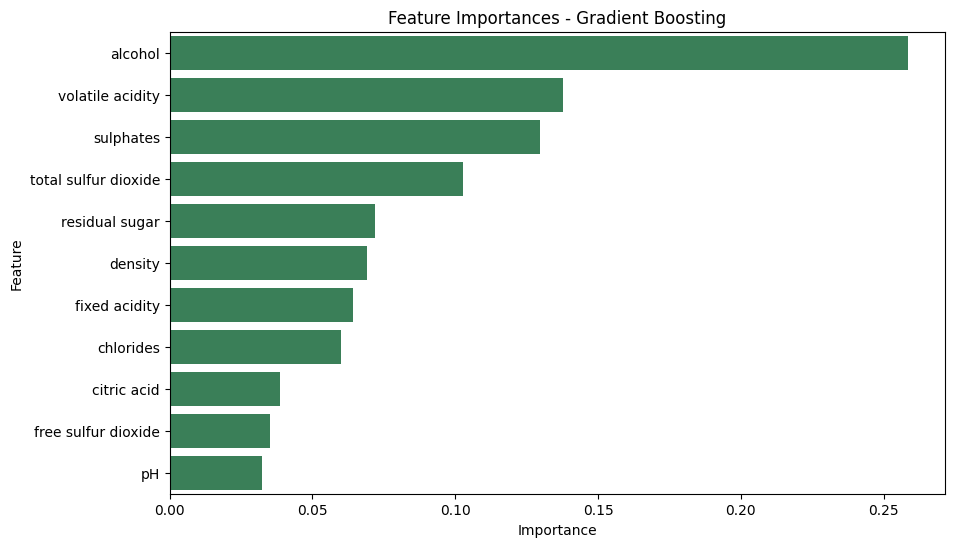

                 Feature  Importance
10               alcohol    0.258433
1       volatile acidity    0.137784
9              sulphates    0.129543
6   total sulfur dioxide    0.102715
3         residual sugar    0.071797
7                density    0.069046
0          fixed acidity    0.064359
4              chlorides    0.060127
2            citric acid    0.038641
5    free sulfur dioxide    0.035299
8                     pH    0.032256


In [12]:
# Feature Importances for Gradient Boosting
importances = gb_model.feature_importances_
feature_names = X.columns
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature', color='#2E8B57')  
plt.title('Feature Importances - Gradient Boosting')
plt.show()
print(feat_imp_df)

##
Reflection: Alcohol emerged as the strongest contributor to the Gradient Boosting model’s predictions, followed by volatile acidity and sulphates. This aligns with wine chemistry, as these attributes directly shape taste, aroma, and overall sensory quality, making them natural drivers of the model’s decisions.

### Overview of Performance
Both ensemble models-Random Forest (87.5% test accuracy, 0.866 F1) and Gradient Boosting (86.3% test accuracy, 0.841 F1)-substantially outperform naive baselines (~60–70% majority-class accuracy). Their strength comes from capturing non-linear relationships among physicochemical features. Class imbalance toward medium quality affects raw performance, but weighted F1 compensates by accounting for minority classes. Performance gaps highlight Random Forest’s overfitting, while Gradient Boosting generalizes more smoothly.

### Key Insights:

Evaluated Random Forest (100) and Gradient Boosting (100) on red wine quality (low/medium/high).

1. Random Forest (RF):

   - Highest raw performance: Test Accuracy ~88.8%, Test F1 ~0.87.
   - Perfect training scores → slight overfitting (Accuracy Gap 0.1125, F1 Gap 0.1339).
   - Strongest on the dominant medium class; weakest on low due to rarity.

2. Gradient Boosting (GB):
   - Slightly lower Test Accuracy ~85.6%, Test F1 ~0.84.
   - Lower training scores → better generalization (gaps smaller than RF: Accuracy Gap 0.1039, F1 Gap 0.1173).
   - Captures low-quality wines slightly better, robust to class imbalance.

### The Best Model for Red Wine Quality Prediction
   - Gradient Boosting offers the strongest overall balance of performance and stability. Its smaller generalization gaps and clearer feature signals such as the influence of sulphates (12.9%) on stability and sulfur dioxide levels (10.3%) on preservation make it the more dependable and interpretable choice for real winemaking decisions.
   - Random Forest provides the highest raw accuracy, which makes it useful for operational screening tasks where quickly flagging lower-quality wines is the priority. However, its perfect training scores and larger gaps indicate overfitting, making it less reliable in unseen conditions compared to Gradient Boosting.

### Next Steps for a Competition-Winning Predictor

   - SMOTE + class weights for 90%+ F1 on highs.
   - XGBoost/LightGBM stacking atop RF-GB.
   - Interactions (alcohol * sulphates) + RobustScaler.
   - 10-fold CV; monitor via ROC-AUC.
   - Augment with UCI white wine for cross-type robustness.
   - SHAP dashboards for winemaker explainability.

## 7.1 Peer review: My Models vs. Others


Notebook link to Alissa's work: (https://github.com/abeaderstadt/applied-ml-beaderstadt/blob/main/notebooks/project05/ensemble-beaderstadt.ipynbLinks)


## 
Alissa's Test Results

| Model                     | Train Accuracy | Test Accuracy | Train F1  | Test F1   | Accuracy Gap | F1 Gap   |
|---------------------------|----------------|---------------|-----------|-----------|--------------|----------|
| Random Forest (100)       | 1.000000       | 0.8875        | 1.000000  | 0.866056  | 0.112500     | 0.133944 |
| Voting (DT + SVM + NN)    | 0.928069       | 0.8500        | 0.911619  | 0.832465  | 0.078069     | 0.079154 |



## 
My Test Results

| Model                     | Train Accuracy | Test Accuracy | Accuracy Gap | Train F1  | Test F1   | F1 Gap   |
|---------------------------|----------------|---------------|--------------|-----------|-----------|----------|
| Random Forest (100)       | 1.000000       | 0.887500      | 0.112500     | 1.000000  | 0.866056  | 0.133944 |
| Gradient Boosting (100)   | 0.960125       | 0.856250      | 0.103875     | 0.958410  | 0.841106  | 0.117304 |


### 
Reflections:

- Random Forest achieves the highest test accuracy (0.8875) and F1 (0.866) but shows overfitting (gaps: 0.113/0.134). 
- Alissa’s Voting Ensemble is stable with smaller gaps (~0.078–0.079), offering reliable predictions across classes. 
- Overall, Gradient Boosting or Voting Ensemble balance accuracy and stability, while Random Forest excels for raw accuracy.